In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:42:43.435110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:42:45.059970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 5000
end_idx = 5200
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(200, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(200, 96, 7)
(134400,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(200, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(200, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:42:54.849431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:42:57.885151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step
CPU time: 3820.6290052938275 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

7/7 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.39211851 0.05048963 0.92491095 ... 0.48048325 0.15333209 0.7130006 ]
Fitness value of the best solution = 0.0029878762783464925


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

7/7 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


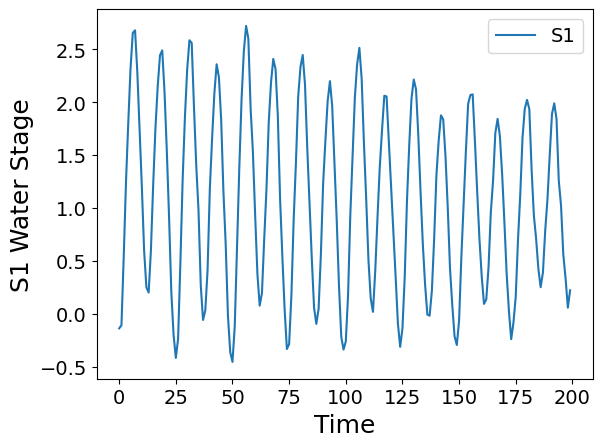

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low8.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.392119,0.050490,0.924911,0.539742,0.651553,0.726917,0.840170,0.484069,0.594287,0.303985,...,0.057027,0.991503,0.243789,0.511767,0.587504,0.061002,0.202612,0.593248,0.633204,0.739161
1,0.132737,0.189954,0.092797,0.875464,0.324637,0.054864,0.837227,0.586257,0.139448,0.152620,...,0.771162,0.311314,0.685761,0.813395,0.272161,0.120629,0.126945,0.346853,0.559477,0.707882
2,0.774378,0.438143,0.288654,0.667402,0.160871,0.142838,0.028554,0.501464,0.701902,0.312101,...,0.349145,0.379844,0.503529,0.946681,0.098639,0.325285,0.952005,0.067308,0.361701,0.381239
3,0.665157,0.756130,0.464094,0.632737,0.625299,0.195024,0.333809,0.799308,0.008332,0.862981,...,0.172387,0.361019,0.802027,0.910039,0.308871,0.473836,0.903316,0.646945,0.293153,0.385757
4,0.536542,0.688027,0.458586,0.496229,0.073487,0.932166,0.508614,0.802880,0.542464,0.230877,...,0.725187,0.419762,0.601044,0.685110,0.890321,0.378983,0.853413,0.662670,0.430368,0.022020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.582027,0.197091,0.191926,0.565623,0.164304,0.299752,0.370958,0.692617,0.947180,0.902137,...,0.373312,0.070871,0.617216,0.801369,0.984076,0.157953,0.532458,0.839420,0.950975,0.055734
196,0.229996,0.805114,0.056336,0.283324,0.857561,0.044221,0.278359,0.414137,0.336831,0.937499,...,0.091420,0.782768,0.522639,0.687141,0.553072,0.629272,0.382952,0.998869,0.186841,0.731327
197,0.238170,0.512814,0.987490,0.765484,0.644728,0.246314,0.624593,0.609368,0.320565,0.560142,...,0.010974,0.816351,0.448987,0.580662,0.716444,0.254944,0.549815,0.190640,0.407234,0.443305
198,0.735413,0.884943,0.854436,0.056924,0.040386,0.293471,0.258234,0.834454,0.552000,0.685885,...,0.119942,0.717978,0.321478,0.792062,0.429802,0.441085,0.094085,0.162835,0.931564,0.707869


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low8.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.138406,-0.129049,-0.135781,-0.227837,0.003278,-0.274932,-0.139483,-0.181277,0.643428,0.739307,...,1.746772,1.791465,0.925735,1.141644,1.108317,1.134961,0.395224,0.608913,0.573372,0.568375
1,-0.108821,-0.228608,-0.129809,-0.127633,0.577464,0.229339,0.475021,0.503584,1.231690,1.170030,...,1.132178,1.096699,0.423036,0.766822,0.639633,0.578092,-0.197012,0.187809,0.006940,-0.095428
2,0.537746,0.216585,0.534768,0.556538,1.228160,1.307079,1.187790,1.250186,1.811489,1.738788,...,0.562105,0.478499,-0.123095,0.267995,0.009354,-0.074087,-0.396146,-0.018351,-0.246917,-0.351721
3,1.247298,1.138394,1.259107,1.293156,1.885772,1.863046,1.789036,1.913952,2.410333,2.190970,...,0.272285,0.039230,-0.248054,0.093968,-0.068979,-0.218845,-0.023580,0.231662,0.026311,-0.001026
4,1.802243,1.599341,1.814225,1.857784,2.266562,1.897719,2.145684,2.301374,2.662028,2.539706,...,0.001309,-0.218188,-0.010773,0.139170,0.236311,0.032635,0.516531,0.583323,0.659812,0.598080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.021817,0.788156,1.054146,1.034839,0.705120,0.607206,0.748038,0.763880,0.382117,0.476223,...,1.765912,1.810178,1.708770,1.943485,1.763589,1.794200,1.738097,1.901921,1.823742,1.928364
196,0.558380,0.753680,0.606799,0.550669,0.392997,0.464313,0.412451,0.366030,0.188955,0.465631,...,1.652415,1.803609,1.678120,1.713100,1.682247,1.770887,1.392961,1.581430,1.483940,1.534030
197,0.334630,0.553094,0.427310,0.381531,0.155024,0.292018,0.134300,0.066188,0.132160,0.355032,...,1.763127,1.848785,1.232223,1.291701,1.362741,1.403410,1.006271,1.155676,1.063036,1.087178
198,0.057268,0.244392,0.055458,0.043928,0.133218,0.270942,0.103147,0.089958,0.523479,0.386529,...,1.290128,1.368236,1.059483,1.038137,1.181535,1.197966,0.753770,1.021298,0.858681,0.864544


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 1398, areas: 236.00469476298895


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

7/7 [==============================] - 0s 3ms/step
time steps: 0, areas: 0
time steps: 3105, areas: 770.1444202258172
